# Shor's Algorithm - Normal without walkers

## The algorithm

This algorithm is used for finding the prime factors for the RSA encryption.

This algorithm takes advantage of Modular arithmetic and GCD (Greatest Common Divisor) to find the prime factors in a complexity time of $ O(N * log(N)) $, unlike classical algorithms where the time complexity is $ O(N^2) $.

## Overview

### The Magic formula

This is known as the magic formula because of the non-intuitive mathmatical properties it uses. The formula goes as follows:

1. We start by choosing wich value we want to find the prime factors from (this is usually the number contained in the public key). For example, let's take N = 21.
2. We then choose a random number so that $0 < x < N$.
3. Now we do modular arithmetic. If we do $x^k mod N$, and increment $k$, we will end with a pattern (this is a mathmatical property), where the results reset. We can now measure the pattern length $l$ and we have 2 options:
   - $l$ even: we can transform $x^l$ into ${x^{(l/2)}}^2$
   - $l$ odd: repeat this step with a different $x$
  
For $x=2$ and $N=21$, we have:
$
\\
2^1 mod 21 = 2 \\
2^2 mod 21 = 4 \\
2^3 mod 21 = 8 \\
2^4 mod 21 = 16 \\
2^5 mod 21 = 11\\
2^6 mod 21 = 1\\
2^7 mod 21 = 2\\
$
We can see that the pattern will start to repeat again, so we can conclude that $l=6$ and so $x^6 = (x^3)^2$

4. Now let's find $z$ so that $z^2 = {x^{(l/2)}}^2$. Finally, we can find the prime factors by doing the Greatest Common Division: $gcd(N, z+-1)$

\begin{equation}
z^2 = {x^{(l/2)}}^2 \equiv z = {2^{3}} \equiv z = 8
\end{equation}

\begin{equation}
gcd(N, x+-1) = gcd(21, 8+-1) = {7, 3}
\end{equation}

So, 21 has 3 and 7 as prime factors ($3*7=21$)

## Implementation

To construct this algorithm, we will need to apply Quantum Fourier Tansforms (QFT) and Quantum Phase Estimation. The algorithm consists in applying the magic formula in a quantum context.

We first need $3n$ qubits to implement the algorithm. We will denominate the first $2n$ qubits as $\ket{x}$ and the remaining $n$ qubits as $\ket{w}$

1. Apply the Hadamard gate to $\ket{x}$ so that they are in a superposition state.
2. Create the Oracle $U_{a,N}$ to all qubits so that $\ket{x}\ket{w} => \ket{x} \ket{w XOR f_{a,N}(x)}$ where $f_{a_N}(x) = a^x mod(N)$. Alternatively, you can also create a controlled $U$ gate for every $\ket{x}$ qubit where the qubit in $\ket{x}$ is the control qubit and $\ket{w}$ is the target.

4. Optionally, measure $\ket{w}$ just to check.
5. Apply the adjoint of the Quantum Fourier Transform ($QFT^{+}$) to $\ket{x}$.
6. Finally, measure $\ket{x}$. From here we can have the period. The period is equivalent to the length of the pattern


## Quantum Circuit

High level overview of the Shor's algorithm circuit. Bear in mind that this circuit is using the inverse of the $QFT$ instead of the adjoint
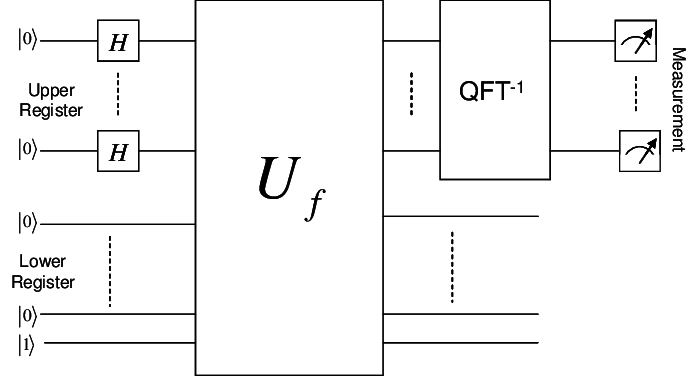

# Implementation

We will be doing Shor's algorithm to find the prime factors of *15* and using $a=7$
This is based on the implementation in https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

Imports

In [16]:
from qiskit import *
from qiskit_aer import *
from qiskit.visualization import plot_histogram
import numpy as np

15 in binary is 1111, which means we will be needing len(1111) * 3 = 12 qubits ($\ket{x}$ needs $2n$ qubits and $\ket{w}$ needs $n$ qubits)

### Implementing the Oracle
Since $a=7$ and $N=21$, we can define an oracle $U$ such as:
\begin{equation}
U\ket{y}=\ket{ay\ mod\ 15}
\end{equation}

Now we simply repeat the cycle $x$ times. 

This implementation is really specific for this case. We could create a more general version of this circuit but for simplicity and clarity this kind of circuit will suffice

In [18]:
def c_amod15(a, power):
    # gdc(15, a) must be one
    if a not in [2, 4, 7, 8, 11, 13]:
        raise ValueError("not valid")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,12]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4,11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod"
    c_U = U.control()
    return c_U

We will also need the QFT (Quantum Fourrier Transform)

In [19]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

Now we can easily finish the circuit

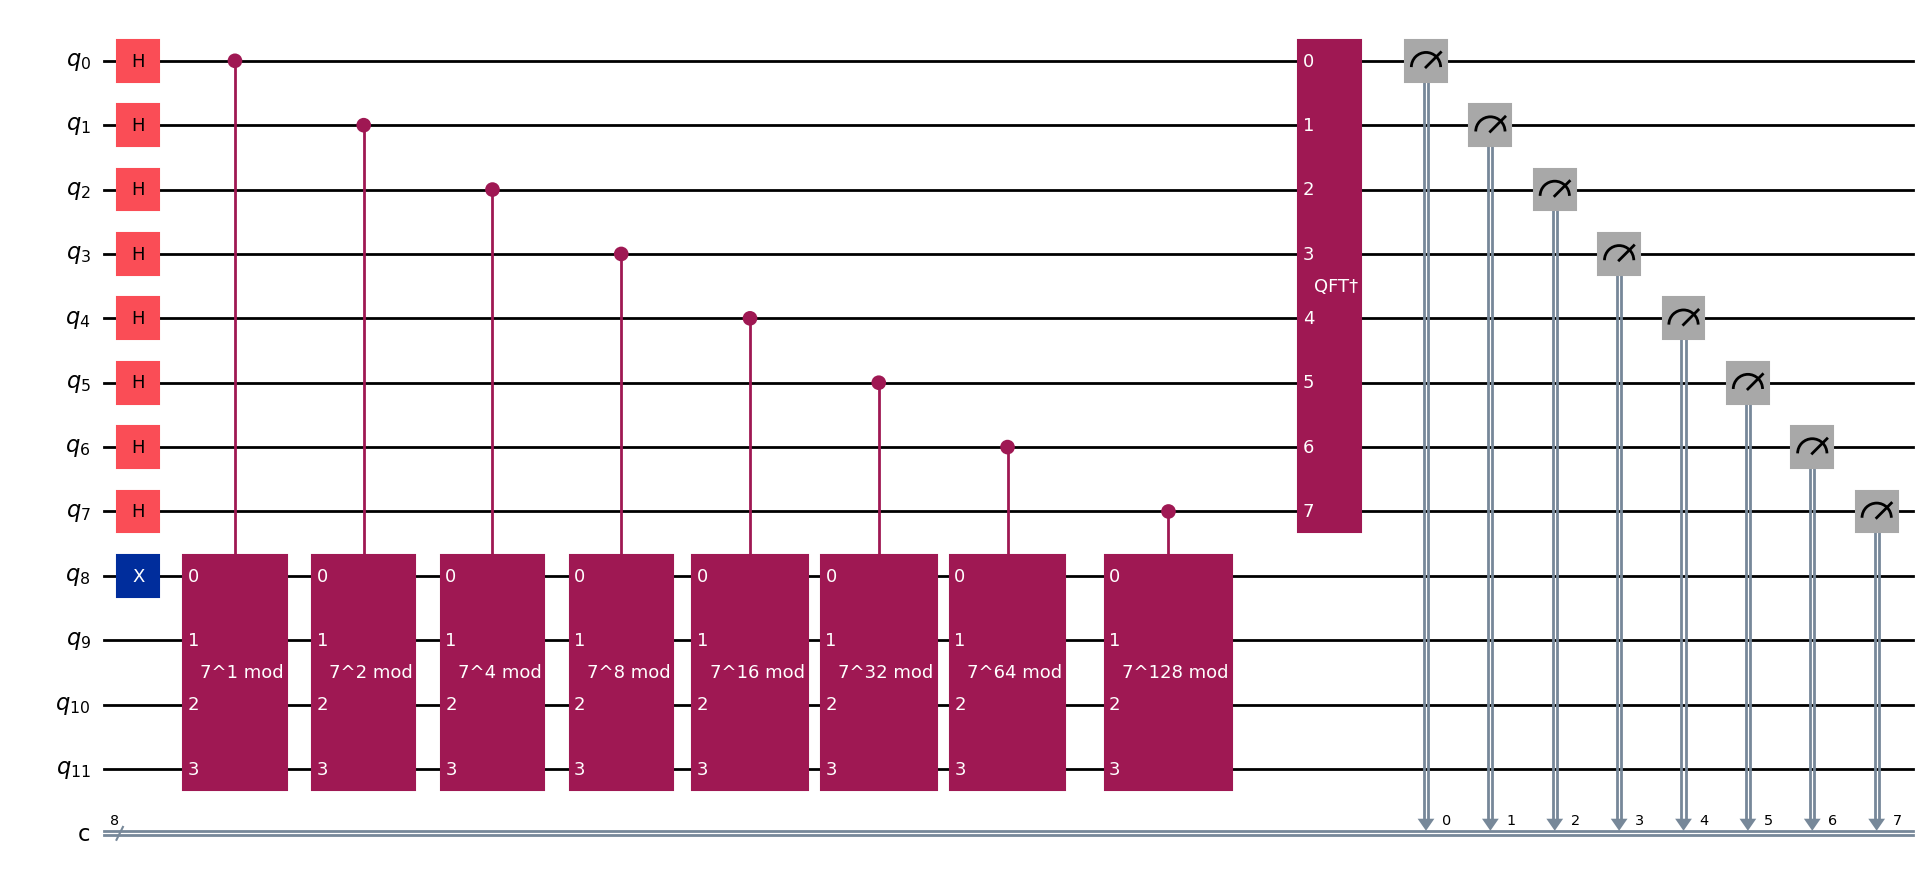

In [34]:
#define the oracle circuit
circuit = QuantumCircuit(12, 8)

a = 7

for q in range(8):
    circuit.h(q)

circuit.x(8)

for q in range(8):
    circuit.append(c_amod15(a, 2**q), [q] + [i + 8 for i in range(4)])

circuit.append(qft_dagger(8), range(8))

circuit.measure(range(8), range(8))

circuit.draw(output="mpl", fold=-1)


Finally, let's measure it

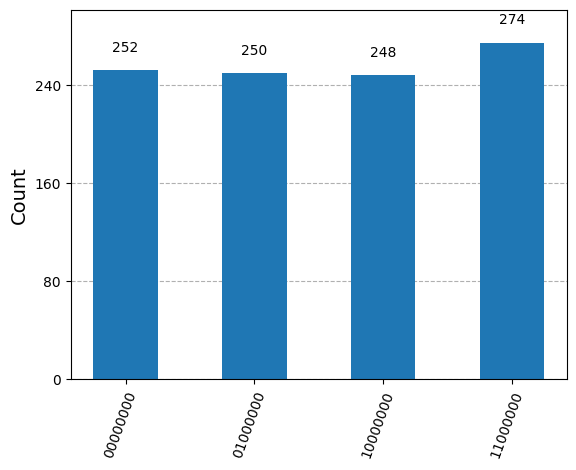

In [35]:
aer_sim = Aer.get_backend('aer_simulator')
t_circuit = transpile(circuit, aer_sim)
counts = aer_sim.run(t_circuit).result().get_counts()
plot_histogram(counts)

This, however, still does not gives us the $r$ (period), but we can determine that from the results:
- Number of possible states: $2^8=256$
- Now let's divide each result for the number of possible states
    - $\ket{00000000}/256 = 0/256 = 0$
    - $\ket{01000000}/256 = 64/256 = 1/4$
    - $\ket{10000000}/256 = 128/256 = 2/4$
    - $\ket{10000000}/256 = 192/256 = 3/4$
- We can easily infer, based on the results, that the period $r$ equals **4** 
- $7^{4/2} = 49$ - This is the $z = x^2$

\begin{equation}
gcd(15, 49 -1) = gcd(15, 48) = 3
\end{equation}

\begin{equation}
gcd(15, 49 +1) = gcd(15, 50) = 5
\end{equation}
- $3 * 5 = 15$
